# Predicting a Film's IMDb Rating via Regression and Deep Learning

![reddit](images/reddit.jpg)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

## Overview

We have so far performed exploratory data analysis (EDA) and cleaned both our DataFrames of all missing values and issues.  We are now ready to start predicting IMDb rating given our set of remaining features:

In [1]:
# import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Let's read in the data we left off in our previous [notebook](EDA_2.ipynb):

In [2]:
# reading in csv from prev notebook
df = pd.read_csv("data/final_df.csv")

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

df.head()

Number of rows: 34819
Number of columns: 9


,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


In [3]:
# reading in csv with budget, revenue, and cert data
df_budget = pd.read_csv("data/final_dfbudget.csv")

print("Number of rows:", df_budget.shape[0])
print("Number of columns:", df_budget.shape[1])

df_budget.head()

Number of rows: 5053
Number of columns: 12


,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


Both csvs were read in correctly and the dimensions of the DataFrames are what we expected.

### Check for Missing Values

Let's quickly verify that we don't have missing values in our final DataFrames:

In [4]:
# number of missing values in both DataFrames
print("Number of missing values in df:", df.isna().sum().sum())
print("Number of missing values in df_budget:", df_budget.isna().sum().sum())

Number of missing values in df: 0
Number of missing values in df_budget: 0


Great, nothing to worry here.

### Check Data Type of Each Column

Let's quickly check the data type of each column was imported correctly:

In [5]:
# data type per column in df
df.dtypes

title                    object
genre                    object
belongs_to_franchise      int64
production_company       object
runtime                 float64
popularity              float64
release_season           object
release_month            object
averageRating           float64
dtype: object

In [6]:
# data type per column in df_budget
df_budget.dtypes

title                    object
budget                  float64
revenue                 float64
genre                    object
belongs_to_franchise      int64
production_company       object
cert                     object
runtime                 float64
popularity              float64
release_season           object
release_month            object
averageRating           float64
dtype: object

The data type for each column is appropriate.  No need to reformat our data

---
## REGRESSION MODELLING

### It's an Iterative Process!

The way we'll create our multiple linear regression model is through an iterative process.  We'll first create a baseline model where we'll use _all_ the variables available to predict `averageRating`.  The purpose of this baseline model is to serve as a base of comparison for all subsequent models.  After each model iteration, we'll record a couple of evaluation metrics and see how they differ from our baseline.  The goal is to create our final model through this iterative process!

**Note:** we'll start off by using the data found in `df` rather than `df_budget`.  This is because `df` has a lot more data and the original purpose of creating `df_budget` was to see how adding `budget`, `revenue`, and `cert` into our model would affect the model's results!

### Creating Dummy Variables

Before we create our multiple linear regression model to predict `averageRating`, we have to reformat our categorical features first.  In order for our regression models to understand our categorical data, we must create new features called _dummy variables_.  We also must define what our basis of comparison will be for each categorical feature:

* `genre`: as seen in the previous notebook, "Horror" is the worst-performing genre in terms of IMDb rating.  Therefore, we'll set this genre to be our base class/level

* `production_company`: seeing as we set apart the top 5 film studios, let's use "Other" as our base of comparison

* `cert`: there isn't a "real" baseline here - it's quite arbitrary.  Therefore, we'll just use "G" as our baseline

* `release_month`: as mentioned before, January is known to be the worst month in cinema.  Let's set this as our base class/level

* `release_season`: given that summer is known for huge blockbusters, let's set that class as our baseline


Below we convert our categorical features (in both DataFrames) into $n-1$ dummy variables (where $n$ = number of unique terms in the variable) so our regression model knows how to interpret them.  I decided to use my function `create_dummies()` from `data_cleaning.py` as we can input the baseline class of our choice:

In [7]:
from Code import data_cleaning as dc

# CREATING DUMMIES FOR DF
# genre
df_genre_dummies = dc.create_dummies(df["genre"], "Horror")
# production_company
df_pc_dummies = dc.create_dummies(df["production_company"], "Other")
# release_season
df_season_dummies = dc.create_dummies(df["release_season"], "Summer")
# release_month
df_month_dummies = dc.create_dummies(df["release_month"], "Jan")

# preview
df_genre_dummies.head()

,Other,Adventure,Romance,Comedy,Action,Drama,Crime,Fantasy,Thriller,Documentary
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


### Constructing our Baseline Model

This naïve, baseline model will use all the features available in `df` to predict our target variable: `averageRating`.  Even though `release_month` and `release_season` are both time variables and may be highly related to one another, we'll include both of them in this model:

In [8]:
# preview df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


Since we'll probably be transforming, re-scaling, and/or filtering data, we'll create a DataFrame for each model called `df_model` which will include all the necessary variables for that model instance.  We'll keep `df` and `df_budget` intact:

In [9]:
# import statsmodels since it's easy to calculate model summary statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

# create DataFrame for this model
df_model = pd.concat([df, df_genre_dummies, df_pc_dummies,
                      df_season_dummies, df_month_dummies], axis = 1)

# we'll always be dropping these original categorical variables
drop_list = ["title", "genre", "production_company", 
             "release_season", "release_month"]

# dropping categorical variables
df_model = df_model.drop(drop_list, axis = 1)
# y
response = "averageRating"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating the Model's Performance

We've successfully fit our baseline model with *all* predictors!

While there are several ways to evaluate the performance of a multiple linear regression model, in this project we'll take a look at 3 main evaluation metrics/methods: *Adjusted R-Squared*, the model's residual diagnostics, and *Root Mean Squared Error (RMSE)*.

* The _adjusted R-Squared_ value should tell us how much of the variation in `averageRating` is explained by our predictors
* The residual diagnostics are always important to check as a regression model should follow the regression residual assumptions
* The RMSE should inform us of how concentrated the data is around our line of best fit (the residual standard deviation)

**Note:** the RMSE will be calculated by performing 5 fold cross-validation!

#### Adjusted R-Squared

In [10]:
# baseline model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     318.9
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:42:11   Log-Likelihood:                -47706.
No. Observations:               34819   AIC:                         9.547e+04
Df Residuals:                   34789   BIC:                         9.573e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3328      0.031    108.014      0.000       3.272       3.393
belongs_to_franchise     0.0409      0.017      2.452      0.014       0.008       0.074
runtime                  0.0139      0.000     42.170      0.000       0.013       0.015
popularity               0.0129      0.001     15.367      0.000       0.011       0.015
Other                    0.9483      0.027     35.692      0.000       0.896       1.000
Adventure                0.7301      0.034     21.462      0.000       0.663       0.797
Romance                  0.9717      0.037     26.072      0.000       0.899       1.045
Comedy                   0.7953      0.023     34.000      0.000       0.749       0.841
Action                   0.4900      0.026     18.956      0.000       0.439       0.541
Drama                    1.1321      0.023     49.349      0.000       1.087       1.177
Crime                    1.1189      0.032     34.743      0.000       1.056       1.182
Fantasy                  0.6152      0.046     13.401      0.000       0.525       0.705
Thriller                 0.4439      0.033     13.598      0.000       0.380       0.508
Documentary              1.9670      0.028     69.033      0.000       1.911       2.023
Disney                   0.2261      0.027      8.314      0.000       0.173       0.279
Sony                     0.1139      0.033      3.439      0.001       0.049       0.179
NBCUniversal             0.2559      0.035      7.346      0.000       0.188       0.324
ViacomCBS                0.2323      0.035      6.644      0.000       0.164       0.301
WarnerMedia              0.1870      0.029      6.420      0.000       0.130       0.244
Fall                     0.4807      0.009     53.047      0.000       0.463       0.498
Winter                   0.5265      0.015     35.894      0.000       0.498       0.555
Spring                   0.4369      0.009     47.488      0.000       0.419       0.455
Oct                      0.1319      0.014      9.616      0.000       0.105       0.159
Dec                      0.1930      0.015     12.851      0.000       0.164       0.222
Feb                      0.0512      0.025      2.062      0.039       0.003       0.100
Nov                      0.1559      0.015     10.278      0.000       0.126       0.186
May                      0.1883      0.015     12.221      0.000       0.158       0.219
Apr                      0.1210      0.015      7.889      0.000       0.091       0.151
Aug                      0.5969      0.017     35.150      0.000       0.564       0.630
Sep                      0.6891      0.015     45.751      0.000       0.660       0.719
Jul                      0.6027      0.019     31.736      0.000       0.565       0.640
Jun                      0.1275      0.016      8.059    

### Comments on the Model's Summary Output

* Unfortunately the baseline model has a relatively low *adjusted R-Squared* value of 0.209
* It is important to note that even though the dummies for `release_season` and `release_month` are considered significant, both variables shouldn't be added to the model given how related they are to one another
* Assuming all other variables remain fixed, IMDb rating is expected to increase by 0.04 (on average) when looking at films belonging to a franchise (relative to standalone films)
* Documentary and Drama are the predictors with largest coefficients in this model (compared to the baseline genre of Horror).
---
Now, let's check if our baseline model meets the regression assumptions about the residuals:

* Residuals are normally distributed
* Residuals have a mean of 0 and have constant spread

#### Residual Diagnostics

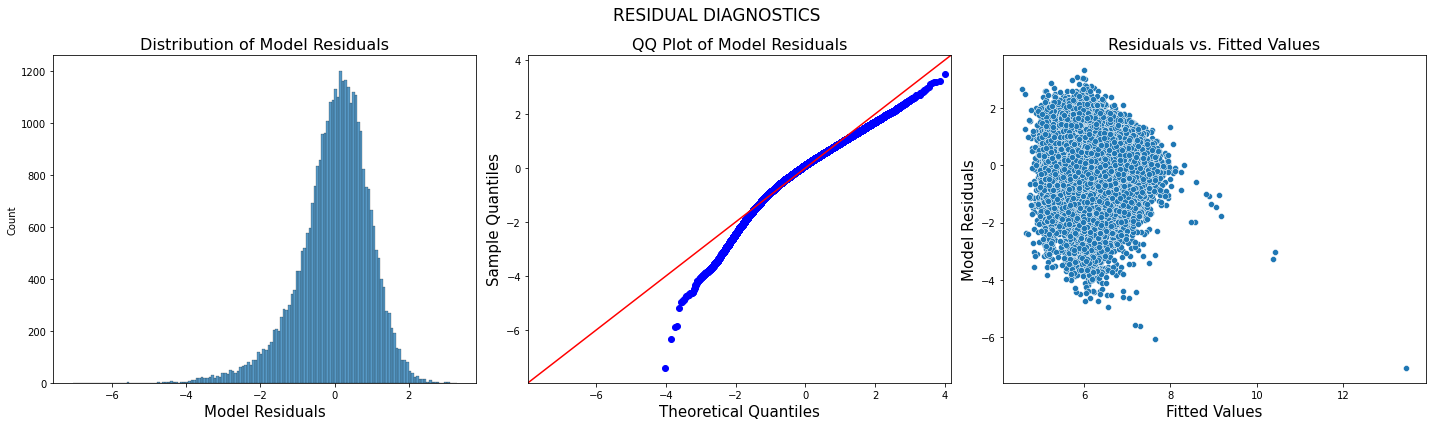

In [11]:
from Code import model_eval as me

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))
# plot histogram, QQ plot, and residuals vs. fitted values
me.residual_diagnostics(fig, axes, model)

While the histogram suggests that the residuals follow a normal distribution, the QQ plot to the right reveals skewness on the left.  The _Residuals vs. Fitted Values_ plot shows that the residuals don't really have a mean of 0 and the variance changes as we move from left to right.  **This model therefore violates the residual assumptions of normality, constant spread, and mean of 0.**

---

#### Cross-validated RMSE

In order to compare the baseline model with all subsequent models, we'll perform 5-fold cross-validation, calculate the Mean Squared Error (MSE) on each fold, and then compute the root Mean Squared Error (RMSE) across all 5 folds:

In [12]:
# calculate train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating", 5)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.95
5 Fold CV Test RMSE: 0.965


The RMSE values are fairly close to one another.  This generally implies that our model did not overfit the data, since its performance with the testing data was as good as the performance with the training data.  This gives us an idea of the average error in our predictions.

---

## Model 1

### Analysing the Relationship between Predictor and Response

Having seen the summary for our baseline model, it is clear that further tuning is needed.  Let's take a look at the relationship between `averageRating` and each predictor in `df`:

In [13]:
# preview df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


### Categorical Features and `averageRating`

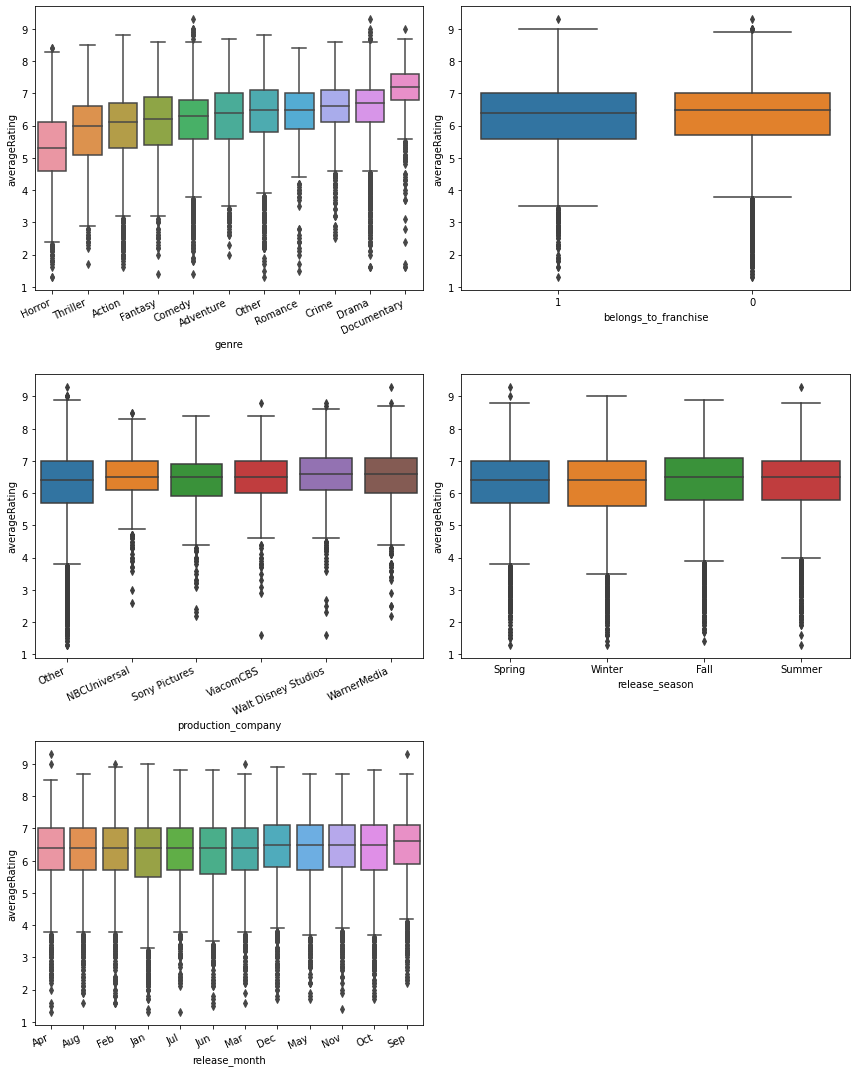

In [14]:
from Code import eda

fig, axes = plt.subplots(3, 2, figsize = (12, 15))
fig.delaxes(axes[2,1])
# desired categorical features to visualise
cats = ["genre", "belongs_to_franchise", "production_company", 
        "release_season", "release_month"]
# plot boxplots of averageRating per categorical feature
eda.plot_cats(df, cats, fig, axes)

* The variable where the distribution of `averageRating` changes the most is `genre`
* The distribution of `averageRating` is fairly similar regardless if the film belongs to a franchise or not
* There doesn't seem to be a big difference in `averageRating` when looking at `production_company`
* The IMDb rating does not seem to be affected very much on the release season
* Despite January being considered the worst month in cinema, April seems to be the worst month in `df` (still, no _real_ difference between months)

---

### Continuous Features and `averageRating`

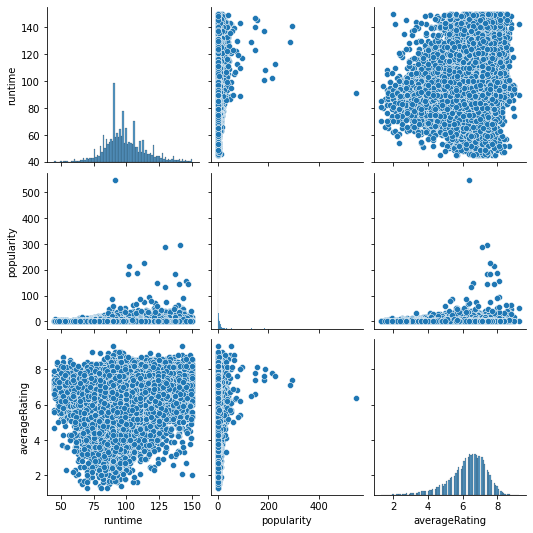

In [15]:
# relationship between response and continuous features
sns.pairplot(df.drop("belongs_to_franchise", axis = 1));

* Both `runtime` and `popularity` don't really have a strong relationship with `averageRating`
* `popularity` and `runtime` don't have a trend either - suggest they're independent of each other

---

### Investigating `popularity`

Recall from our previous [notebook](EDA_2.ipynb) that `popularity` had a right-skewed distribution:

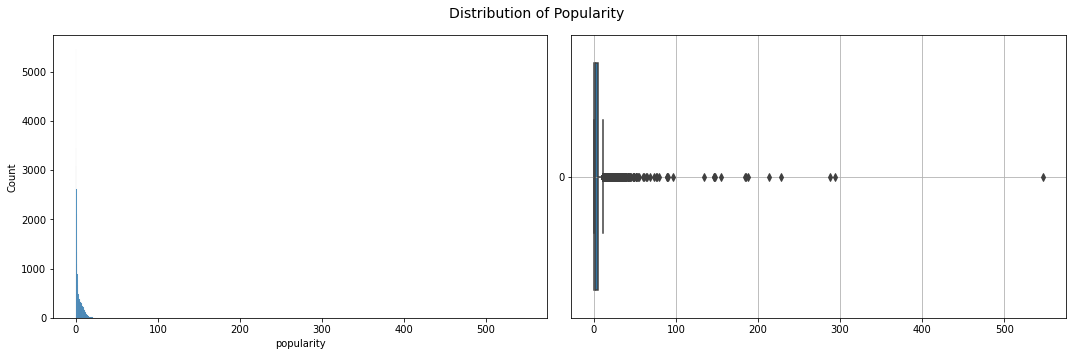

In [16]:
# quick refresher on how popularity is distributed
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Distribution of Popularity", fontsize = 14)
sns.histplot(data = df["popularity"], ax = axes[0])
sns.boxplot(data = df["popularity"], orient = "h", ax = axes[1])
axes[1].grid();

fig.tight_layout()

As both plots above show, most films in `df` have a `popularity` value close to 0!  Given the heavy skewness of this distribution, it'd be a good idea to remove the most "extreme" outliers.  Let's see how many films have a `popularity` score greater than, say, 50:

In [17]:
# percent of films with popularity score > 50
(sum(df["popularity"] > 50) / len(df))*100

0.09190384560153939

_Only 0.09% of our data has a popularity score over 50!_  This being the case, let's get rid of any film with a `popularity` score over 50:

In [18]:
# dropping films with popularity score > 50
df = df[df["popularity"] <= 50]
df.reset_index(drop = True, inplace = True)
# recreating dummies
df_genre_dummies = dc.create_dummies(df["genre"], "Horror")
df_pc_dummies = dc.create_dummies(df["production_company"], "Other")
df_season_dummies = dc.create_dummies(df["release_season"], "Summer")
df_month_dummies = dc.create_dummies(df["release_month"], "Jan")

### Transforming `popularity`

One of the assumptions in regression is that the numeric features in our DataFrame are normally distributed.  While this may be the case with `runtime`, the distribution for `popularity` is far from normal.  In these scenarios, a transformation is usually applied to the variable in order to make it more normal-like.  Common transformations for right-skewed data are: log, square root, cubic root, and so on.

Below I applied six transformations to `popularity` and plotted the corresponding histogram.  The purpose of doing this is to see which transformation makes the distribution of `popularity` best resemble a normal distribution:

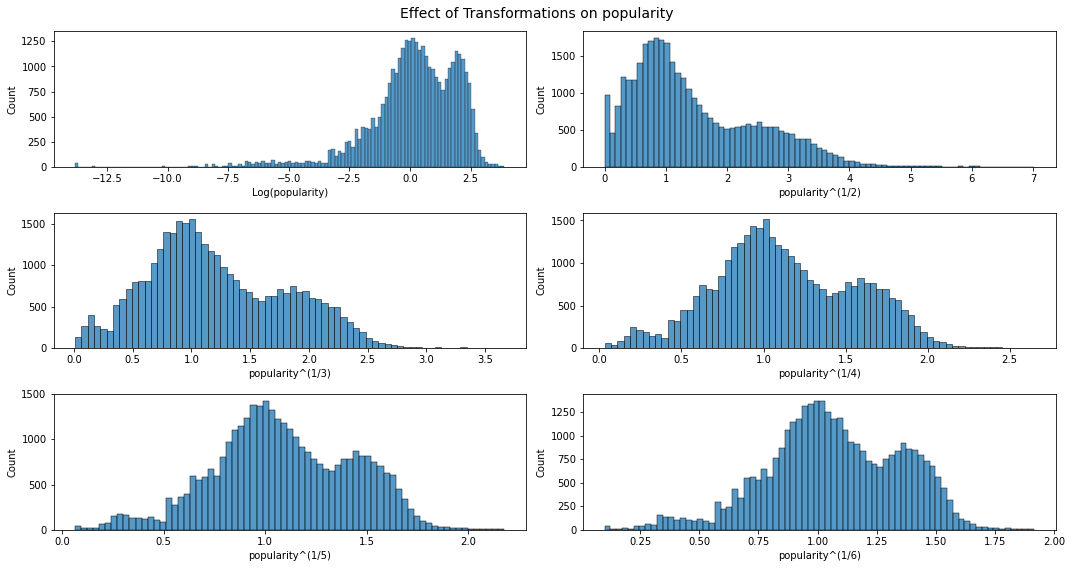

In [19]:
# effect of transformations on popularity
fig, axes = plt.subplots(3, 2, figsize = (15,8))

fig.suptitle("Effect of Transformations on popularity", fontsize = 14)

n = 1
for i in range(6):
    row = i // 2
    col = i % 2
    if n == 1:
        sns.histplot(np.log(df["popularity"]), ax = axes[row, col])
        axes[row, col].set_xlabel("Log(popularity)")
    else:
        sns.histplot(df["popularity"]**(1/n), ax = axes[row, col])
        axes[row, col].set_xlabel("popularity^(1/{})".format(n))
    n += 1

fig.tight_layout();

The distribution of `popularity` starts to approach a somewhat normal distribution when we take the nth root of `popularity`, however, as $n$ increases, the distribution already starts having a slight left skewness.  It is important to note that these transformations also change our distribution into something a little more bi-modal.

I decided to apply a fifth root transformation to `popularity` and save it as `popularity_fifth`:

In [20]:
# transforming popularity
popularity_fifth = df["popularity"]**(1/5)
popularity_fifth.name = "popularity_fifth"

---

### Selecting the Features for Model 1

For Model 1, I decided to remove `release_month` and keep `release_season` instead.  Rather than including 11 dummy variables that could potentially overfit the data, let's just include 3 with `release_season`.  Furthermore, `release_month` did not seem to have much of an effect as seen by the boxplot with our response variable.  I will also be dropping `belongs_to_franchise` since there wasn't much difference in `averageRating` between groups.  Finally, this model will be using `popularity_fifth` instead of `popularity`:

In [21]:
# preview df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


In [22]:
# create DataFrame
df_model = pd.concat([df, popularity_fifth, df_genre_dummies, 
                      df_pc_dummies, df_season_dummies], axis = 1)
# drop original categorical variables + belongs_to_franchise + popularity
df_model = df_model.drop(drop_list + ["belongs_to_franchise", 
                                      "popularity"], axis = 1)
# y
response = "averageRating"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating Model 1

#### Adjusted R-Squared

In [23]:
# summary for Model 1
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     466.6
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:43:32   Log-Likelihood:                -47618.
No. Observations:               34787   AIC:                         9.528e+04
Df Residuals:                   34766   BIC:                         9.545e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.7191      0.039     96.151      0.000       3.643       3.795
runtime              0.0131      0.000     39.037      0.000       0.012       0.014
popularity_fifth     0.3253      0.016     19.772      0.000       0.293       0.358
Other                0.9806      0.027     36.906      0.000       0.929       1.033
Adventure            0.7462      0.034     21.971      0.000       0.680       0.813
Romance              0.9965      0.037     26.807      0.000       0.924       1.069
Comedy               0.8104      0.023     34.764      0.000       0.765       0.856
Action               0.5003      0.026     19.392      0.000       0.450       0.551
Drama                1.1599      0.023     50.807      0.000       1.115       1.205
Crime                1.1354      0.032     35.365      0.000       1.072       1.198
Fantasy              0.6200      0.046     13.522      0.000       0.530       0.710
Thriller             0.4500      0.033     13.829      0.000       0.386       0.514
Documentary          2.0262      0.029     70.740      0.000       1.970       2.082
Disney               0.2095      0.027      7.699      0.000       0.156       0.263
Sony                 0.0900      0.033      2.714      0.007       0.025       0.155
NBCUniversal         0.2400      0.035      6.892      0.000       0.172       0.308
ViacomCBS            0.2089      0.035      5.971      0.000       0.140       0.277
WarnerMedia          0.1679      0.029      5.762      0.000       0.111       0.225
Fall                 0.0034      0.014      0.236      0.814      -0.025       0.031
Winter              -0.0673      0.014     -4.721      0.000      -0.095      -0.039
Spring              -0.0509      0.015     -3.450      0.001      -0.080      -0.022
==============================================================================
Omnibus:                     3830.027   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6372.436
Skew:                          -0.776   Prob(JB):                         0.00
Kurtosis:                       4.409   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Comments on the Model's Summary Output

* Unfortunately, our *adjusted R-squared* value only improved slightly from 0.209 to 0.211
* Our transformed `popularity` variable (`popularity_fifth`) was labelled as significant
* NBCUniversal has the largest difference (0.24) when compared to our baseline level ("Other")
* Documentary and Drama are still the covariates with the largest coefficients

---

#### Residual Diagnostics

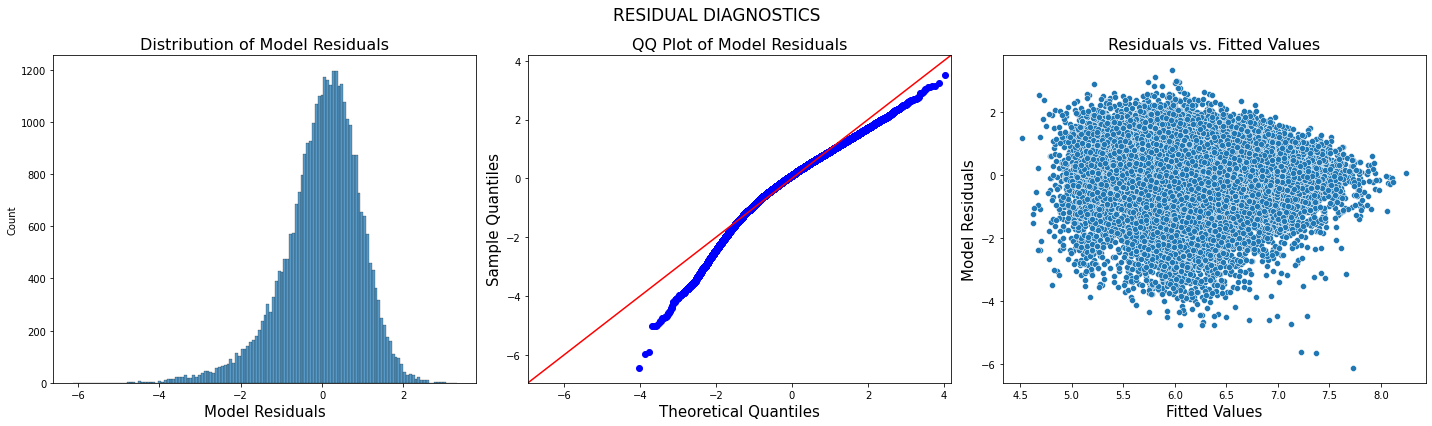

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))
# histogram, QQ plot, residuals vs. fitted values
me.residual_diagnostics(fig, axes, model)

* The residual histogram looks normal but the QQ plot still reveals some skewness
* The residuals are now somewhat centred around 0 and have semi-constant variance

In sum, the residual diagnostics improved compared to our baseline model!  The normality assumption is still violated, however, the centre and spread are looking fairly good.

---

#### Cross-validated RMSE

In [25]:
# calculated 5 fold CV train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating", 5)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.949
5 Fold CV Test RMSE: 0.962


* Both values decreased since our last model iteration, however, the difference is minimal
* Despite a low *adjusted R-Squared* value, both train and test RMSEs are fairly good

---

## Model 2

### Analysing the Nature of our Response Variable: `averageRating`

Sometimes we focus so much on our predictor variables that we lose sight on the most important variable we got: our target variable!

Let's take a closer look at the distribution of `averageRating` in `df`:

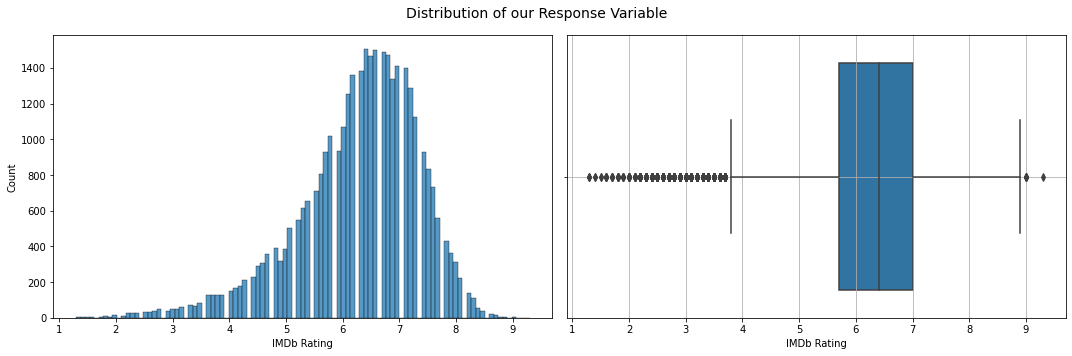

In [26]:
# distribution of averageRating
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Distribution of our Response Variable", fontsize = 14)

sns.histplot(x = df["averageRating"], ax = axes[0])
axes[0].set_xlabel("IMDb Rating")

sns.boxplot(x = df["averageRating"], orient = "h", ax = axes[1])
axes[1].set_xlabel("IMDb Rating")
axes[1].grid();

fig.tight_layout()

Both the histogram and boxplot reveal that the distribution of our response variable is slightly skewed and has a centre around 6.5.  The boxplot specifically labels all films with an IMDb rating less than 3.8(ish) as outliers.

_Although not a requirement for regression modelling_, it's generally a good idea to have a normally distributed response variable.  In this case, we could probably get rid of the outliers by simply applying a transformation.  Similar to how we tackled `popularity`, I'll apply a couple of common transformations used on left-skewed data and we'll see which one most closely resembles a normal distribution:

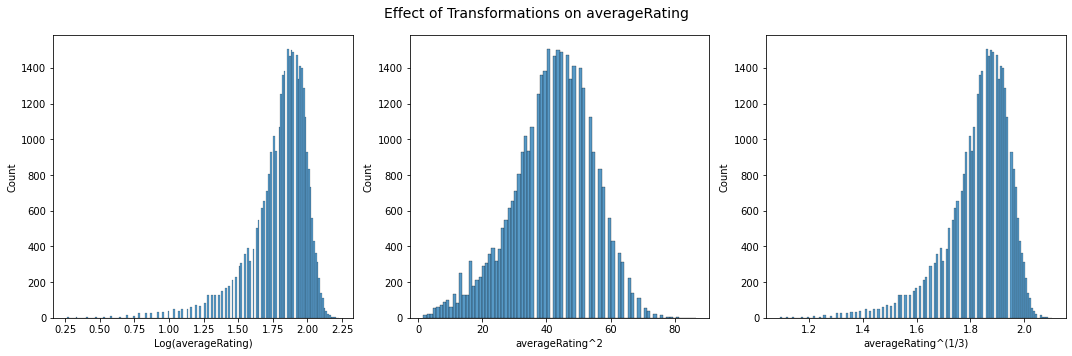

In [27]:
# effect of transformations on averageRating
fig, axes = plt.subplots(1, 3, figsize = (15,5))

fig.suptitle("Effect of Transformations on averageRating", fontsize = 14)
# log
sns.histplot(np.log(df["averageRating"]), ax = axes[0])
axes[0].set_xlabel("Log(averageRating)")
# square
sns.histplot(df["averageRating"]**2, ax = axes[1])
axes[1].set_xlabel("averageRating^2")
# cubic root
sns.histplot(df["averageRating"]**(1/3), ax = axes[2])
axes[2].set_xlabel("averageRating^(1/3)")

fig.tight_layout();

Squaring `averageRating` makes the distribution look more normal.

I'll apply this transformation to our response variable and save it as `averageRating_squared`:

In [28]:
# transforming averageRating
averageRating_squared = df["averageRating"]**2
averageRating_squared.name = "averageRating_squared"

### Checking Predictor Correlations

Another common requirement when it comes to creating a regression model is that the predictors used must be independent of one another.  While we have eliminated some obvious cases before (`original_language` - `spoken_languages`, `original_title` - `title`), we haven't _truly_ checked that all our predictors used are independent of one another.

A common way to verify this is by plotting a heatmap of the correlations between all the variables in our dataset and inspect for values >= |0.8|:

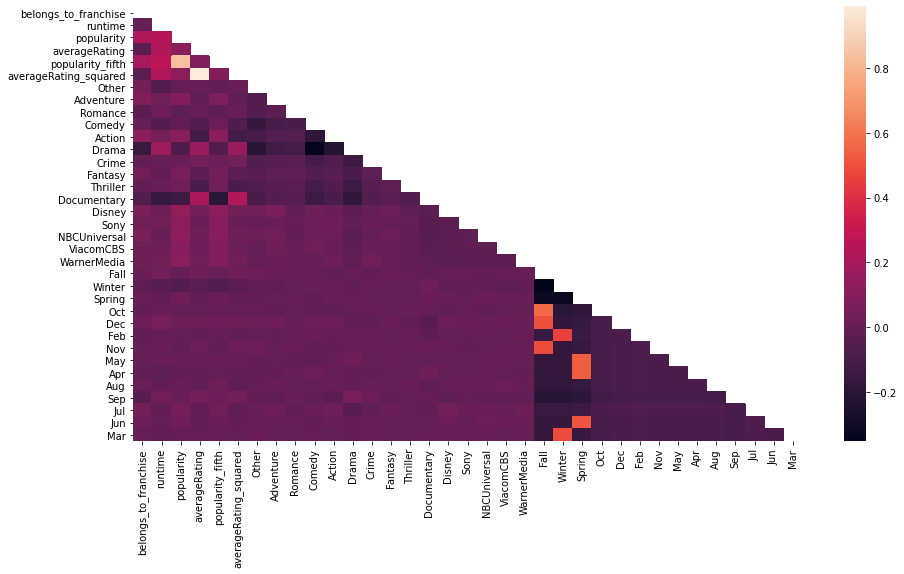

In [29]:
plt.figure(figsize = (15,8))
# DataFrame with ALL variables
df_corr = pd.concat([df, popularity_fifth, averageRating_squared, df_genre_dummies, 
                     df_pc_dummies, df_season_dummies, df_month_dummies], axis = 1)
# correlation heatmap
sns.heatmap(df_corr.corr(), mask = np.triu(np.ones_like(df_corr.corr())));

With the exception of the obvious (`averageRating`/`averageRating_squared`, `popularity`/`popularity_fifth`), none of the variables are highly correlated with one another.  Of course, our month dummy variables will have relatively high correlations with our seasonal dummy variables (films released in `Jan` will always be released during the `Winter`).

### Re-Scaling `runtime`

Having transformed `popularity` into `popularity_fifth`, let's verify that all our numeric features are roughly on the same scale:

In [30]:
# checking characteristics of numeric features in df
pd.concat([df[["runtime"]], popularity_fifth], axis = 1).describe()

,runtime,popularity_fifth
count,34787.000000,34787.000000
mean,98.486187,1.090527
std,16.270699,0.341148
min,45.000000,0.063096
25%,89.000000,0.867732
50%,96.000000,1.065528
75%,108.000000,1.359178
max,150.000000,2.180102


It's clear that `runtime` has its values on a different scale than our other numeric feature, `popularity_fifth`.

This being the case, we'll re-scale `runtime` so both our numeric features are on a similar scale.  We'll use `MinMaxScaler()` from `sklearn.preprocessing`:

In [31]:
# import MinMaxScaler from SciKit-Learn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit and transform scaler to data
runtime_scaled = scaler.fit_transform(df[["runtime"]])
runtime_scaled = pd.DataFrame(runtime_scaled, columns = ["runtime_scaled"])

### Selecting the Features for Model 2

For Model 2, I decided to use the same variables as in Model 1, except for `Fall`.  This model should show us the effect of transforming our response variable and re-scaling `runtime`:

In [32]:
# preview df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


In [33]:
# create DataFrame
df_model = pd.concat([df, runtime_scaled, popularity_fifth, averageRating_squared,
                      df_genre_dummies, df_pc_dummies, df_season_dummies], axis = 1)
# drop original categorical variables + unscaled/untransformed variables
df_model = df_model.drop(drop_list + ["belongs_to_franchise","runtime", 
                                      "popularity", "averageRating", "Fall"], 
                         axis = 1)
# Y
response = "averageRating_squared"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating Model 2

#### Adjusted R-Squared

In [34]:
# summary for Model 2
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     averageRating_squared   R-squared:                       0.218
Model:                               OLS   Adj. R-squared:                  0.218
Method:                    Least Squares   F-statistic:                     511.6
Date:                   Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                           18:44:33   Log-Likelihood:            -1.3314e+05
No. Observations:                  34787   AIC:                         2.663e+05
Df Residuals:                      34767   BIC:                         2.665e+05
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.4798      0.349     50.110      0.000      16.796      18.164
runtime_scaled      16.7533      0.412     40.614      0.000      15.945      17.562
popularity_fifth     3.9370      0.192     20.484      0.000       3.560       4.314
Other               11.2103      0.311     36.099      0.000      10.602      11.819
Adventure            8.3668      0.397     21.077      0.000       7.589       9.145
Romance             11.0739      0.434     25.488      0.000      10.222      11.925
Comedy               8.8919      0.272     32.637      0.000       8.358       9.426
Action               5.4158      0.302     17.960      0.000       4.825       6.007
Drama               13.0990      0.267     49.093      0.000      12.576      13.622
Crime               12.8305      0.375     34.194      0.000      12.095      13.566
Fantasy              7.0961      0.536     13.241      0.000       6.046       8.147
Thriller             4.7765      0.380     12.558      0.000       4.031       5.522
Documentary         24.2579      0.335     72.461      0.000      23.602      24.914
Disney               2.2328      0.318      7.021      0.000       1.609       2.856
Sony                 0.7834      0.388      2.021      0.043       0.024       1.543
NBCUniversal         2.4647      0.407      6.055      0.000       1.667       3.262
ViacomCBS            2.2441      0.409      5.488      0.000       1.443       3.046
WarnerMedia          1.8182      0.340      5.340      0.000       1.151       2.486
Winter              -0.7416      0.144     -5.157      0.000      -1.023      -0.460
Spring              -0.6027      0.151     -3.998      0.000      -0.898      -0.307
==============================================================================
Omnibus:                      251.556   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.366
Skew:                          -0.191   Prob(JB):                     6.47e-58
Kurtosis:                       3.189   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comments on Model's Summary Output

* The *adjusted R-Squared* value increased slightly to 0.218
* No multicollinearity warning anymore
* All our predictors are considered significant in predicting `averageRating_squared`
* Given the transformed response variable, the coefficients are larger than in previous models

---

#### Residual Diagnostics

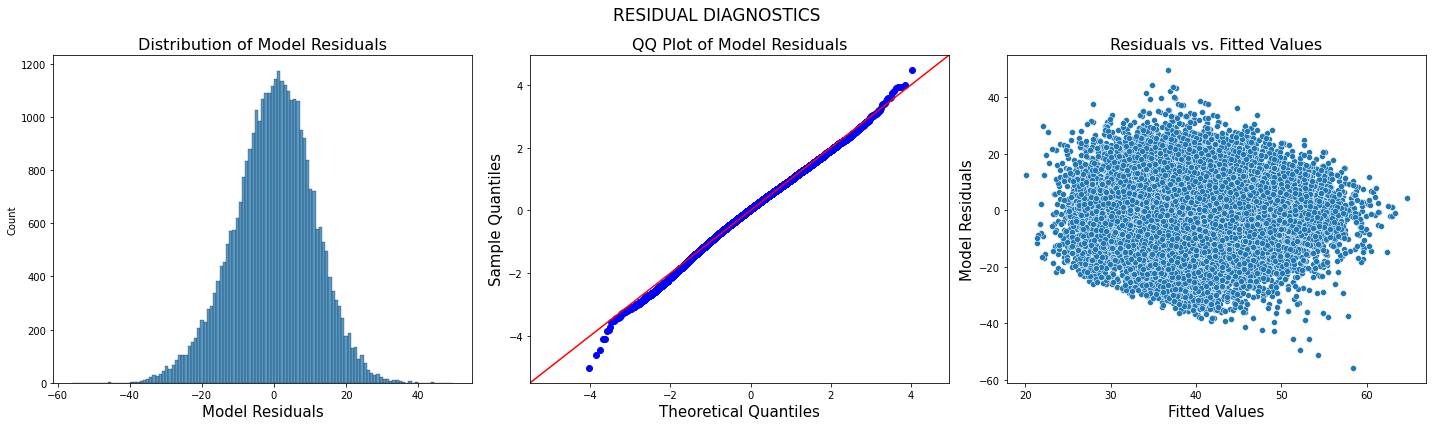

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

me.residual_diagnostics(fig, axes, model)

The residual diagnostics seem to have improved since our last model iteration:

* The distribution of the residuals follows a normal distribution (evidenced by histogram and standard QQ plot)
* The residuals are roughly centred around 0 and the variance has improved since last time

**This model passes the residual assumptions of normality, mean of 0, and constant spread**

---

#### Cross-validated RMSE

In [36]:
# calculated 5 fold CV train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating_squared", 5, squared = True)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.952
5 Fold CV Test RMSE: 0.963


Both training and test RMSE values have remained fairly unchanged at around 0.95.

## Using `df_budget` Instead

Unfortunately, the performance of our multiple linear regression model has not changed much since our baseline iteration.  The *adjusted R-Squared* and CV RMSEs improved very little while the residual diagnostics improved a lot.  The ideal situation would be to have a relatively good *adjusted R-squared* value, residual diagnostics, and small RMSE scores.

We musn't forget that our original dataset downloaded from Kaggle came with a budget and revenue column.  After performing our EDA and cleaning the DataFrame, we realised that both of these columns had a substantial amount of missing data.  However, rather than getting rid of these variables completely, I decided to keep a copy of the DataFrame *with* these two columns and test how they would affect our model's performance.  Furthermore, I also added a third column called `cert` where the film's certification (R, PG, PG-13) is available.

We'll now be using the data found in `df_budget` to create our model.  Similar to how we proceeded with `df`, we'll start off by creating a baseline model with all predictors and then see how we can improve our results:

In [37]:
# preview df_budget
df_budget.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


### Creating Dummies for `df_budget`

In [38]:
# genre
budget_genre_dummies = dc.create_dummies(df_budget["genre"], "Horror")
# production_company
budget_pc_dummies = dc.create_dummies(df_budget["production_company"], "Other")
# cert
cert_dummies = dc.create_dummies(df_budget["cert"], "G")
# release_season
budget_season_dummies = dc.create_dummies(df_budget["release_season"], "Summer")
# release_month
budget_month_dummies = dc.create_dummies(df_budget["release_month"], "Jan")

### Baseline Model (`df_budget`)

In [39]:
# creating DataFrame
df_model = pd.concat([df_budget, budget_genre_dummies, budget_pc_dummies,
                      cert_dummies, budget_season_dummies, budget_month_dummies],
                     axis = 1)
# df_budget has an additional categorical variable
drop_list += ["cert"]
# getting rid of original categorical variables
df_model = df_model.drop(drop_list, axis = 1)

# y
response = "averageRating"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating the Baseline Model (`df_budget`)

#### Adjusted R-Squared

In [40]:
# baseline model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     51.50
Date:                Thu, 29 Apr 2021   Prob (F-statistic):          3.48e-295
Time:                        18:44:50   Log-Likelihood:                -6400.8
No. Observations:                5053   AIC:                         1.287e+04
Df Residuals:                    5018   BIC:                         1.310e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.6169      0.102     35.396      0.000       3.417       3.817
budget               -8.348e-09   4.98e-10    -16.780      0.000   -9.32e-09   -7.37e-09
revenue               2.078e-09   1.28e-10     16.227      0.000    1.83e-09    2.33e-09
belongs_to_franchise    -0.1610      0.031     -5.155      0.000      -0.222      -0.100
runtime                  0.0196      0.001     22.899      0.000       0.018       0.021
popularity               0.0057      0.001      5.801      0.000       0.004       0.008
Animation                0.8759      0.096      9.119      0.000       0.688       1.064
Adventure                0.4782      0.070      6.826      0.000       0.341       0.615
Comedy                   0.2650      0.057      4.660      0.000       0.154       0.377
Action                   0.1978      0.058      3.407      0.001       0.084       0.312
Drama                    0.5652      0.058      9.776      0.000       0.452       0.679
Crime                    0.5963      0.074      8.005      0.000       0.450       0.742
Fantasy                  0.4657      0.091      5.105      0.000       0.287       0.645
Other                    0.5077      0.067      7.523      0.000       0.375       0.640
Romance                  0.4471      0.097      4.627      0.000       0.258       0.636
Thriller                 0.1720      0.080      2.160      0.031       0.016       0.328
Disney                   0.1085      0.043      2.498      0.013       0.023       0.194
Sony                     0.0213      0.048      0.440      0.660      -0.074       0.116
NBCUniversal             0.0950      0.051      1.879      0.060      -0.004       0.194
ViacomCBS                0.1263      0.052      2.426      0.015       0.024       0.228
WarnerMedia              0.1084      0.046      2.352      0.019       0.018       0.199
PG                      -0.3591      0.076     -4.725      0.000      -0.508      -0.210
R                       -0.1583      0.076     -2.087      0.037      -0.307      -0.010
PGThirteen              -0.4322      0.077     -5.595      0.000      -0.584      -0.281
Fall                     0.5519      0.024     23.107      0.000       0.505       0.599
Spring                   0.4967      0.024     20.493      0.000       0.449       0.544
Winter                   0.5538      0.045     12.306      0.000       0.466       0.642
Oct                      0.1817      0.034      5.351      0.000       0.115       0.248
Dec                      0.1969      0.034      5.770      0.000       0.130       0.264
Nov                      0.1733      0.037      4.731      0.000       0.101       0.245
May                      0.2658      0.037      7.207      0.000       0.193       0.338
Jul                      0.6847      0.043     15.914    

### Comment's on the Model's Summary Output

* The *adjusted R-Squared* for our _baseline model_ came out higher than our most tuned model with `df`!
* `budget` and `revenue` coefficients are ridiculously low - rescaling may be needed
* Possible multicollinearity present

---

#### Residual Diagnostics

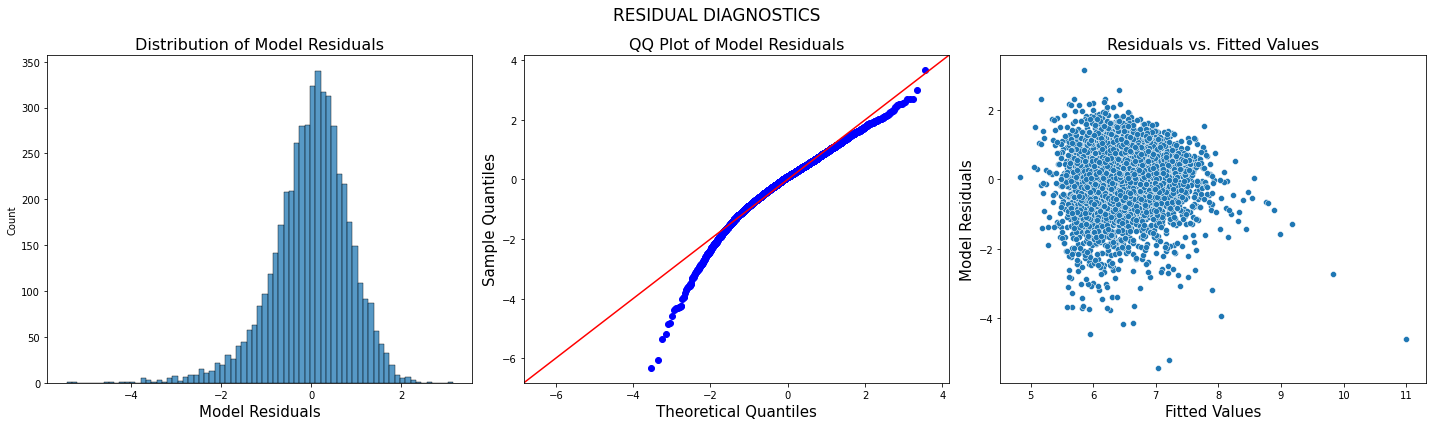

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))
# distribution of residuals, QQ plot, residuals vs. fitted values
me.residual_diagnostics(fig, axes, model)

* The residual plots look very similar to the plots in our residual diagnostics of the baseline model with `df`
* Distribution is somewhat normal but the mean does not equal 0 and the spread is non-constant

---

#### Cross-validated RMSE

In [42]:
# calculate train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating", 5)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.852
5 Fold CV Test RMSE: 1.013


Although the training RMSE is lower than the corresponding value in our other baseline model, the test RMSE is larger.  The large difference between our train and test RMSEs suggest that there may be overfitting!

---

## Model 1 (`df_budget`)

### Checking the Distribution of our Numeric Features

Recall from our previous notebook that `budget`, `revenue`, and `popularity` had strong right-skewed distributions:

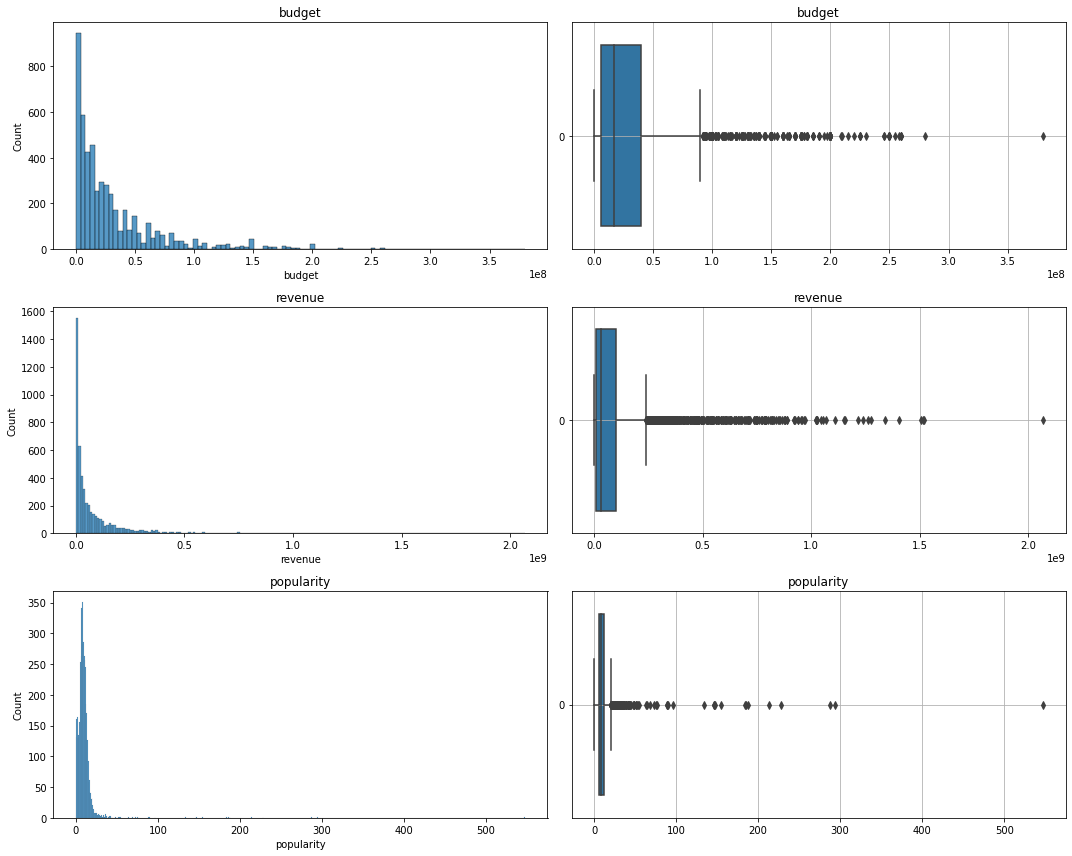

In [43]:
fig, axes = plt.subplots(3, 2, figsize = (15, 12))

eda.plot_numeric(df_budget[["budget", "revenue", "popularity"]], fig, axes)

### Removing Outliers for `revenue` and `popularity`

Before we apply any transformation, we must get rid of some outliers.  `revenue` and `popularity` are the two most skewed distributions out of the three.  Therefore, we'll remove any film that made a revenue over 1 billion _or_ has a popularity score over 50:

In [44]:
logic = ((df_budget["revenue"] <= 1e9) & (df_budget["popularity"] <= 50))
# remove films with revenue over 1 billion or popularity over 50
df_budget = df_budget[logic]
df_budget.reset_index(drop = True, inplace = True)

# recreate dummies
budget_genre_dummies = dc.create_dummies(df_budget["genre"], "Horror")
budget_pc_dummies = dc.create_dummies(df_budget["production_company"], "Other")
cert_dummies = dc.create_dummies(df_budget["cert"], "G")
budget_season_dummies = dc.create_dummies(df_budget["release_season"], "Summer")
budget_month_dummies = dc.create_dummies(df_budget["release_month"], "Jan")

### Transforming `budget`, `revenue`, and `popularity`

We'll be applying a fourth root transformation to `budget`, a square root transformation to `popularity` and a 5th root transformation to `revenue` in order to make them look more normal:

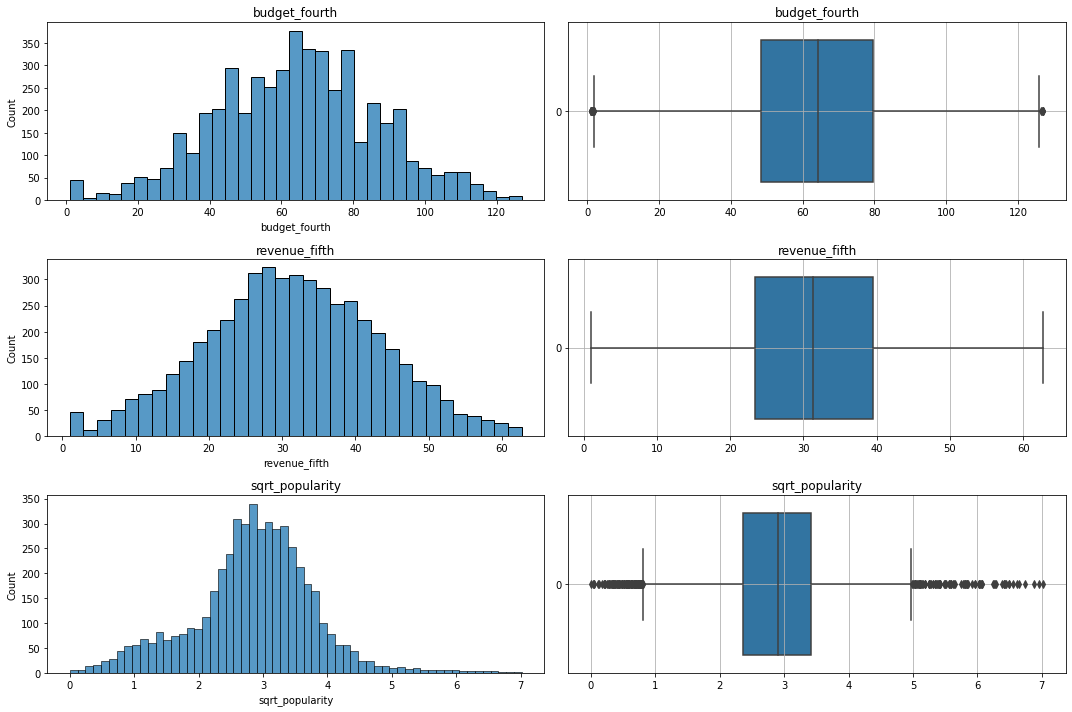

In [45]:
fig, axes = plt.subplots(3, 2, figsize = (15,10))
# fourth root of budget
budget_fourth = df_budget["budget"]**(1/4)
budget_fourth.name = "budget_fourth"
# fifth root of revenue
revenue_fifth = df_budget["revenue"]**(1/5)
revenue_fifth.name = "revenue_fifth"
# square root of revenue
sqrt_popularity = np.sqrt(df_budget["popularity"])
sqrt_popularity.name = "sqrt_popularity"

eda.plot_numeric(pd.concat([budget_fourth, revenue_fifth, 
                            sqrt_popularity], axis = 1), fig, axes)

### Checking the Distribution of `averageRating`

As we did with the data in `df`, let's check and see if the distribution of `averageRating` in `df_budget` is normally distributed:

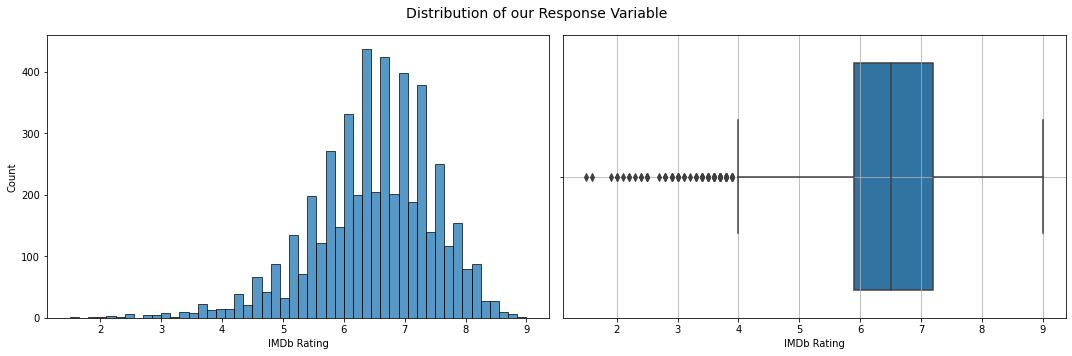

In [46]:
# distribution of averageRating
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Distribution of our Response Variable", fontsize = 14)

sns.histplot(x = df_budget["averageRating"], ax = axes[0])
axes[0].set_xlabel("IMDb Rating")

sns.boxplot(x = df_budget["averageRating"], orient = "h", ax = axes[1])
axes[1].set_xlabel("IMDb Rating")
axes[1].grid()

fig.tight_layout();

The distribution is slightly left-skewed with a couple of outliers below an IMDb rating of 4.

Let's see how the distribution looks if we square this variable:

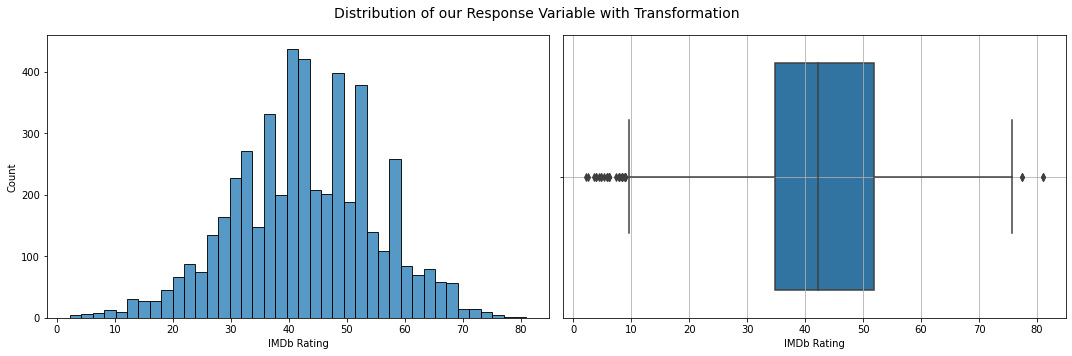

In [47]:
# distribution of averageRating with transformation
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Distribution of our Response Variable with Transformation", 
             fontsize = 14)

sns.histplot(x = df_budget["averageRating"]**2, ax = axes[0])
axes[0].set_xlabel("IMDb Rating")

sns.boxplot(x = df_budget["averageRating"]**2, orient = "h", ax = axes[1])
axes[1].set_xlabel("IMDb Rating")
axes[1].grid()

fig.tight_layout();

Given that squaring our response variable returns a normally distribution, we'll save this data in `averageRating_squared`:

In [48]:
# saving data with transformation
averageRating_squared = df_budget["averageRating"]**2
averageRating_squared.name = "averageRating_squared"

### Checking the Correlations between our Features

As done in with `df`, let's check that none of our variables are highly correlated with one another:

In [49]:
# preview df_budget
df_budget.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


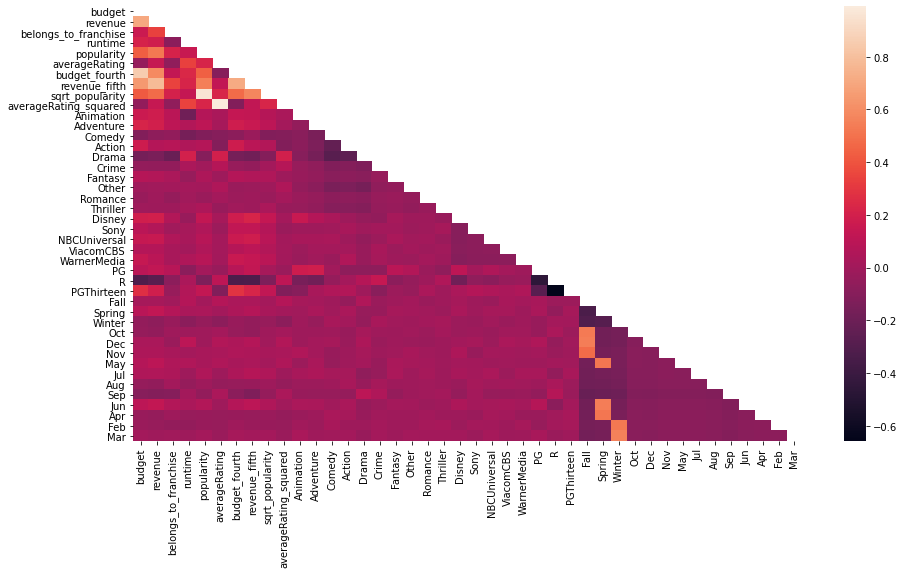

In [50]:
plt.figure(figsize = (15,8))
# DataFrame with ALL variables
df_corr = pd.concat([df_budget, budget_fourth, revenue_fifth, sqrt_popularity,
                     averageRating_squared, budget_genre_dummies, 
                     budget_pc_dummies, cert_dummies, budget_season_dummies, 
                     budget_month_dummies], axis = 1)
# correlation heatmap
sns.heatmap(df_corr.corr(), mask = np.triu(np.ones_like(df_corr.corr())));

The upper left corner has the variables with highest pairwise correlations.  Although some of them are trivial (`averageRating`/`averageRating_squared`), let's check and see if any have a correlation value >= |0.8|:

In [51]:
# correlation matrix for top left corner
pd.concat([df_budget[["budget", "revenue", "belongs_to_franchise", "popularity", "runtime"]], 
           budget_fourth, revenue_fifth, sqrt_popularity, averageRating_squared], axis = 1).corr()

,budget,revenue,belongs_to_franchise,popularity,runtime,budget_fourth,revenue_fifth,sqrt_popularity,averageRating_squared
budget,1.000000,0.706155,0.164649,0.433533,0.216739,0.855286,0.648141,0.422018,-0.056462
revenue,0.706155,1.000000,0.340258,0.520917,0.188383,0.588148,0.784100,0.476458,0.144164
belongs_to_franchise,0.164649,0.340258,1.000000,0.217828,-0.082538,0.130249,0.341895,0.209586,-0.060974
popularity,0.433533,0.520917,0.217828,1.000000,0.152782,0.443135,0.552118,0.959825,0.229696
runtime,0.216739,0.188383,-0.082538,0.152782,1.000000,0.242578,0.219354,0.137824,0.345139
budget_fourth,0.855286,0.588148,0.130249,0.443135,0.242578,1.000000,0.715269,0.479575,-0.116432
revenue_fifth,0.648141,0.784100,0.341895,0.552118,0.219354,0.715269,1.000000,0.577514,0.124352
sqrt_popularity,0.422018,0.476458,0.209586,0.959825,0.137824,0.479575,0.577514,1.000000,0.229161
averageRating_squared,-0.056462,0.144164,-0.060974,0.229696,0.345139,-0.116432,0.124352,0.229161,1.000000


Barring the obvious (`budget`/`budget_fourth`, etc.), none of the predictors have a correlation that exceeds 0.8!

---

### Selecting Features for Model 1 (`df_budget`)

We have transformed `budget`, `revenue`, and `popularity` into semi normal distributions and transformed our response variable.  Let's see how these changes affects the model's results!  We'll also remove `release_month` here and include `release_season`:

In [52]:
# preview df_budget
df_budget.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


In [53]:
# creating DataFrame
df_model = pd.concat([df_budget, budget_fourth, revenue_fifth, sqrt_popularity, 
                      averageRating_squared, budget_genre_dummies, budget_pc_dummies, 
                      cert_dummies, budget_season_dummies], axis = 1)
# getting rid of original categorical variables + untransformed variables
df_model = df_model.drop(drop_list + ["budget", "revenue", "popularity", 
                                      "averageRating"], axis = 1)
# y
response = "averageRating_squared"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating Model 1 (`df_budget`)

#### Adjusted R-Squared

In [54]:
# summary output for Model 1
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     averageRating_squared   R-squared:                       0.370
Model:                               OLS   Adj. R-squared:                  0.366
Method:                    Least Squares   F-statistic:                     112.3
Date:                   Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                           18:46:11   Log-Likelihood:                -18509.
No. Observations:                   5009   AIC:                         3.707e+04
Df Residuals:                       4982   BIC:                         3.725e+04
Df Model:                             26                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.0889      1.379      7.317      0.000       7.386      12.792
belongs_to_franchise    -3.0849      0.359     -8.586      0.000      -3.789      -2.380
runtime                  0.2526      0.010     25.680      0.000       0.233       0.272
budget_fourth           -0.2984      0.010    -31.016      0.000      -0.317      -0.280
revenue_fifth            0.3402      0.020     16.958      0.000       0.301       0.380
sqrt_popularity          3.7787      0.184     20.561      0.000       3.418       4.139
Animation               14.4013      1.086     13.259      0.000      12.272      16.531
Adventure                8.1836      0.794     10.309      0.000       6.627       9.740
Comedy                   5.4689      0.648      8.439      0.000       4.198       6.739
Action                   4.8741      0.664      7.344      0.000       3.573       6.175
Drama                    9.0787      0.658     13.807      0.000       7.790      10.368
Crime                    9.0520      0.845     10.712      0.000       7.395      10.709
Fantasy                  7.7478      1.034      7.496      0.000       5.721       9.774
Other                    8.6227      0.769     11.216      0.000       7.116      10.130
Romance                  7.5291      1.095      6.878      0.000       5.383       9.675
Thriller                 3.7786      0.903      4.184      0.000       2.008       5.549
Disney                   0.4030      0.503      0.801      0.423      -0.583       1.389
Sony                    -0.3241      0.557     -0.582      0.561      -1.416       0.768
NBCUniversal             0.9711      0.584      1.663      0.096      -0.174       2.116
ViacomCBS                0.5104      0.596      0.856      0.392      -0.659       1.680
WarnerMedia              0.9687      0.529      1.830      0.067      -0.069       2.007
PG                      -3.9000      0.863     -4.518      0.000      -5.592      -2.208
R                       -1.8980      0.861     -2.204      0.028      -3.586      -0.210
PGThirteen              -4.7634      0.876     -5.439      0.000      -6.480      -3.046
Fall                     1.0177      0.375      2.715      0.007       0.283       1.753
Spring                   0.2232      0.385      0.580      0.562      -0.531       0.977
Winter                  -0.6901      0.396     -1.741      0.082      -1.467       0.087
==============================================================================
Omnibus:                      120.842   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.472
Skew:                          -0.285   Prob(JB):                     5.24e-36
Kurtosis:                       3.673   Cond. No.               

### Comments on the Model's Summary Output

* The *adjusted R-Squared* value went up to 0.367!
* Most of the dummy variables for `production_company` are not significant

---

#### Residual Diagnostics

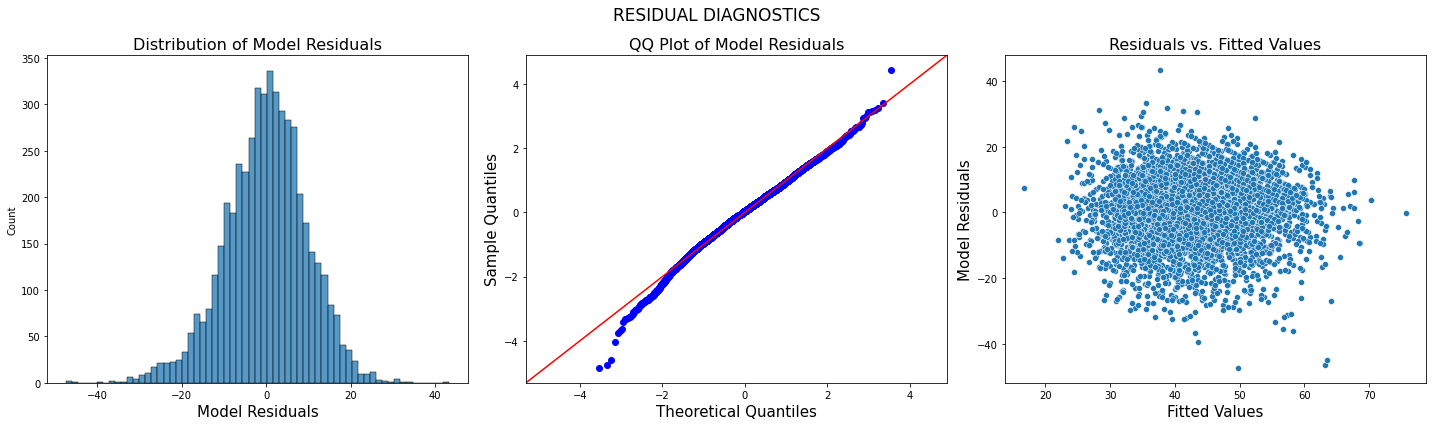

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

me.residual_diagnostics(fig, axes, model)

All of the residual assumptions were met!  The residuals follow a normal distribution, have a mean of 0, and have a constant spread throughout!

**This model passes the residual assumptions of normality, mean of 0, and constant spread**

---

#### Cross-validated RMSE

In [56]:
# 5 fold CV train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating_squared", 5, True)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.802
5 Fold CV Test RMSE: 0.819


Both of these values shrunk compared to our baseline model and are the best results we've obtained (including `df`).  The difference between the train and test results has also shrunk, which means that the model performs well on testing data too.

---

## Model 2 (`df_budget`)

Having normalised our continuous features and transformed our response variable, let's see how each predictor interacts with `averageRating_squared`.

### Categorical Features and `averageRating_squared`

In [57]:
# preview df_budget
df_budget.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


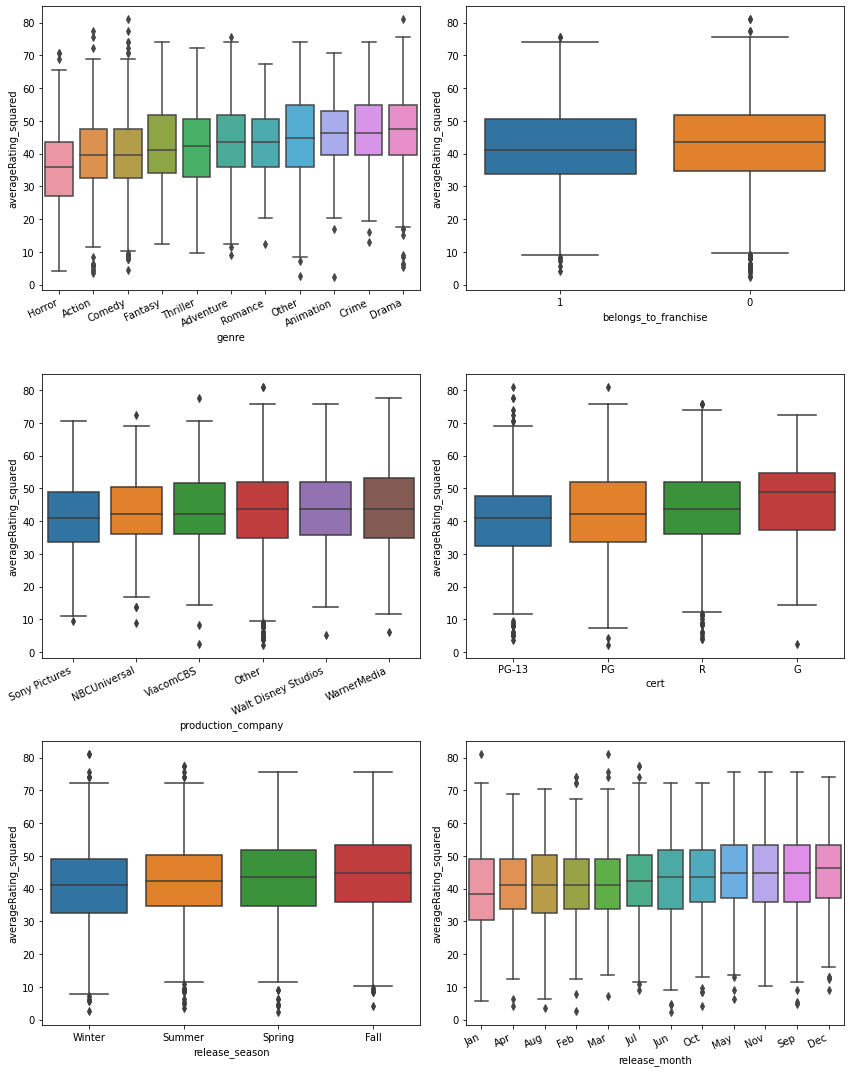

In [58]:
fig, axes = plt.subplots(3, 2, figsize = (12, 15))
# desired categorical features to visualise
cats = ["genre", "belongs_to_franchise", "production_company", 
        "cert", "release_season", "release_month"]

temp_df = pd.concat([df_budget, averageRating_squared], axis = 1)
temp_df.drop("averageRating", axis = 1, inplace = True)

# plot boxplots of averageRating_squared per categorical feature
eda.plot_cats(temp_df, cats, fig, axes)

* Compared to the boxplots shown with `df`, the distribution of our response variable _does_ seem to change between groups
* The biggest difference in our response variable is with `genre`
* Standalone films have a slight edge over franchise films!
* `averageRating_squared` does not seem to change very much between groups in `production_company`
* G-rated films are rated higher (on average) than all other certs
* Winter and January are the worst times to release a film!

---

### Continuous Features and `averageRating_squared`

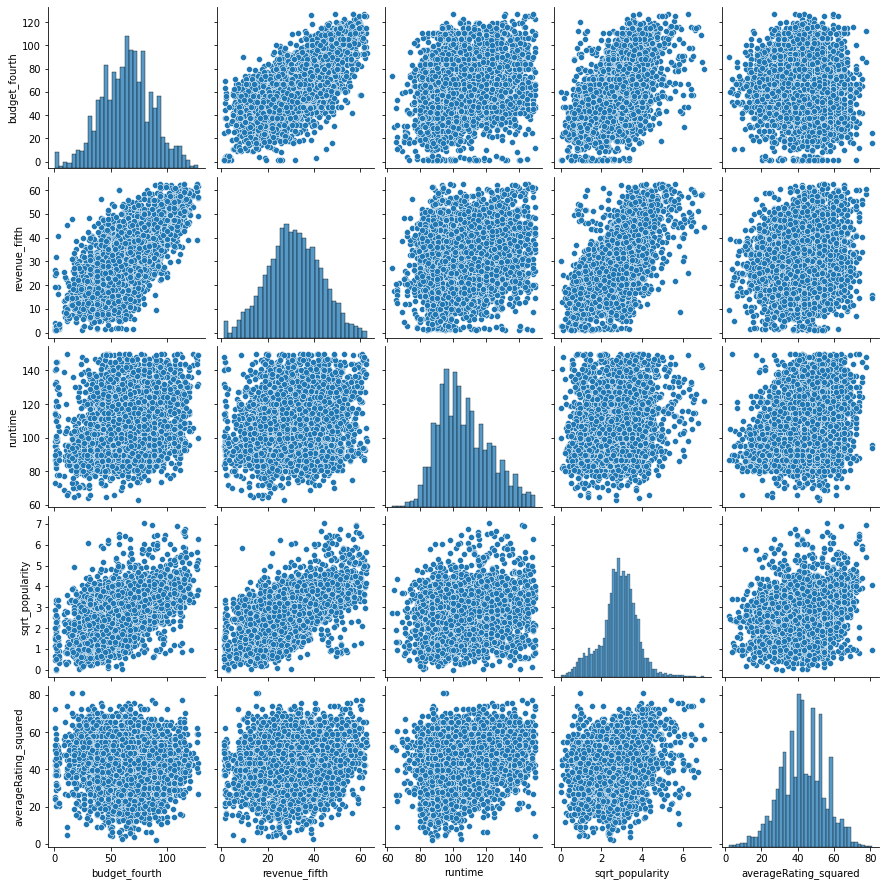

In [59]:
# pairs plot of our numeric features
sns.pairplot(pd.concat([budget_fourth, revenue_fifth, df_budget[["runtime"]], 
                        sqrt_popularity, averageRating_squared], axis = 1));

---

### Selecting Features for Model 2 (`df_budget`)

Having seen the relationship of each variable with respect to our new response variable `averageRating_squared`, I'll drop `production_company` from this model.  This is because its corresponding boxplot revealed that there wasn't a real significant change in `averageRating_squared` between groups:

In [60]:
# preview df_budget
df_budget.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


In [61]:
# creating DataFrame
df_model = pd.concat([df_budget, budget_fourth, revenue_fifth, sqrt_popularity,
                      averageRating_squared, budget_genre_dummies, cert_dummies, 
                      budget_season_dummies], axis = 1)
# getting rid of original categorical variables + untransformed variables
df_model = df_model.drop(drop_list + ["budget", "revenue","popularity", 
                                      "averageRating"], axis = 1)
# y
response = "averageRating_squared"
# X
predictors = df_model.drop(response, axis = 1).columns
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model = ols(formula = f, data = df_model).fit()

### Evaluating Model 2 (`df_budget`)

#### Adjusted R-Squared

In [62]:
# summary output for Model 2
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     averageRating_squared   R-squared:                       0.369
Model:                               OLS   Adj. R-squared:                  0.366
Method:                    Least Squares   F-statistic:                     138.7
Date:                   Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                           18:46:41   Log-Likelihood:                -18513.
No. Observations:                   5009   AIC:                         3.707e+04
Df Residuals:                       4987   BIC:                         3.721e+04
Df Model:                             21                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.0343      1.373      7.309      0.000       7.343      12.726
belongs_to_franchise    -3.0842      0.359     -8.588      0.000      -3.788      -2.380
runtime                  0.2521      0.010     25.703      0.000       0.233       0.271
budget_fourth           -0.2962      0.010    -31.069      0.000      -0.315      -0.277
revenue_fifth            0.3462      0.020     17.614      0.000       0.308       0.385
sqrt_popularity          3.7842      0.184     20.598      0.000       3.424       4.144
Animation               14.3494      1.084     13.237      0.000      12.224      16.475
Adventure                8.1525      0.793     10.281      0.000       6.598       9.707
Comedy                   5.4765      0.647      8.464      0.000       4.208       6.745
Action                   4.8521      0.663      7.313      0.000       3.551       6.153
Drama                    9.0563      0.657     13.787      0.000       7.768      10.344
Crime                    9.0569      0.844     10.726      0.000       7.402      10.712
Fantasy                  7.7054      1.033      7.458      0.000       5.680       9.731
Other                    8.6057      0.769     11.197      0.000       7.099      10.112
Romance                  7.5500      1.095      6.897      0.000       5.404       9.696
Thriller                 3.6986      0.903      4.098      0.000       1.929       5.468
PG                      -3.9093      0.856     -4.566      0.000      -5.588      -2.231
R                       -1.9436      0.849     -2.290      0.022      -3.608      -0.280
PGThirteen              -4.8005      0.865     -5.548      0.000      -6.497      -3.104
Fall                     1.0275      0.374      2.744      0.006       0.293       1.762
Spring                   0.2337      0.384      0.608      0.543      -0.520       0.987
Winter                  -0.6837      0.396     -1.726      0.084      -1.460       0.093
==============================================================================
Omnibus:                      120.009   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.430
Skew:                          -0.284   Prob(JB):                     8.83e-36
Kurtosis:                       3.672   Cond. No.                     2.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* Despite removing `production_company`, the *adjusted R-Squared* remained the same

---

#### Residual Diagnostics

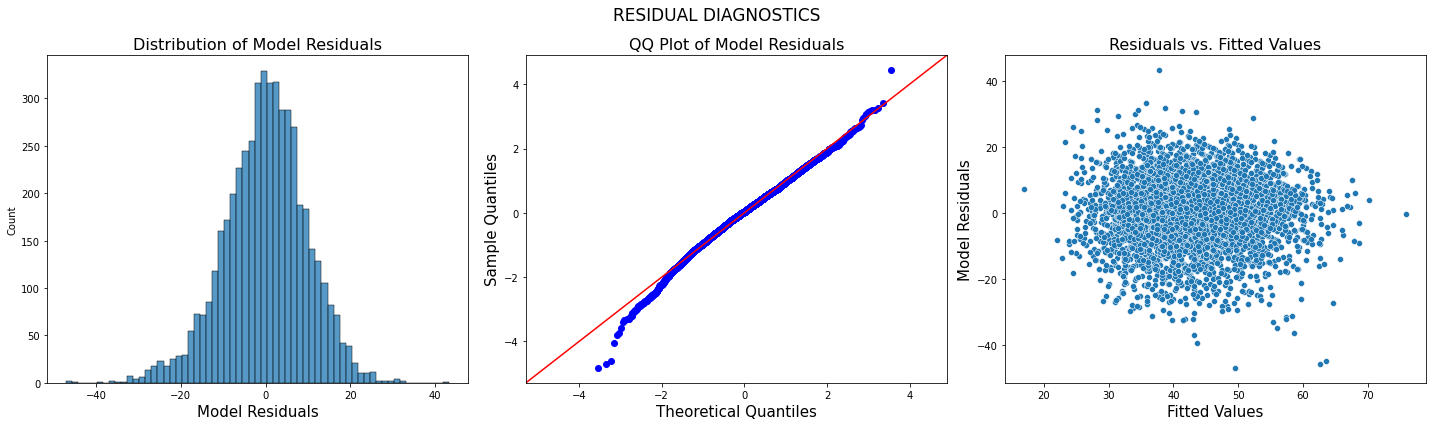

In [63]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

me.residual_diagnostics(fig, axes, model)

All of the residual assumptions were met!  The residuals follow a normal distribution, have a mean of 0, and have a constant spread throughout!

**This model passes the residual assumptions of normality, mean of 0, and constant spread**

---

#### Cross-validated RMSE

In [64]:
# 5 fold CV train and test RMSE
train_RMSE, test_RMSE = me.CV_RMSE(df_model, "averageRating_squared", 5, True)
print("5 Fold CV Train RMSE:", round(train_RMSE, 3))
print("5 Fold CV Test RMSE:", round(test_RMSE, 3))

5 Fold CV Train RMSE: 0.803
5 Fold CV Test RMSE: 0.818


Both our training and testing RMSE values have not changed since our last model.  The small difference between training and test results suggest that our model does not overfit and performs well on testing data.

## FINAL COMMENTS

Unfortunately, despite removing outliers, transforming features, and re-scaling, we were not able to achieve a high *adjusted R-squared* value.  _However_, it is important to note that the residuals met the residual assumptions in multiple linear regression.  Furthermore, the cross-validated training and test RMSE values were pretty close together, which suggests that the model did not overfit the data and performs as well on new data as with the training data.

### Interpretation of Beta Coefficients

Using our last model (`df_budget` Model 2), here is the interpretation of some of the coefficients seen in the model's summary output:

* `Drama` - (holding all other variables constant), we estimate that the _squared_ IMDb rating changes by 9.03 on average when selecting a Drama film _relative to Horror films_
* `belongs_to_franchise` - (holding all other variables constant), we estimate that that the _squared_ IMDb rating changes by -3.1 on average when selecting a film that belongs to a franchise _relative to standalone films_

In [65]:
# saving both DataFrames
# reset index
df = df.reset_index(drop = True)
df_budget = df_budget.reset_index(drop = True)
# final dimensions of df
print(df.shape)
# final dimensions of df_budget
print(df_budget.shape)
# save DataFrames
df.to_csv("data/final_df.csv", index = False)
df_budget.to_csv("data/final_dfbudget.csv", index = False)

(34787, 9)
(5009, 12)


## To be Continued

Having seen the results of using multiple linear regression to predict `averageRating`, let's now focus on how a more advanced neural network model will perform.

To continue on with this project, please click [here](NN.ipynb)